In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ExifTags, UnidentifiedImageError
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
def set_seed(seed_value=42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
#     cudnn.benchmark = False
#     cudnn.deterministic = True
    random.seed(seed_value)
set_seed()

In [3]:
root_folder = "/kaggle/input/BarkVN-50/BarkVN-50_mendeley"

labels = []
file_paths = []
i = 0
# Traverse through the root folder
for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    # Check if it's a directory
    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)

            # Check if the file is an image and can be opened
            try:
                with Image.open(file_path) as img:
                    # If the image can be opened, add it to the lists
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError):
                # If the image cannot be opened, remove the file
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)
    i += 1
# Create a DataFrame
df = pd.DataFrame({"label": labels, "path": file_paths})

# Display the DataFrame
print(df)

                     label                                               path
0                 Wrightia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...
1                 Wrightia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...
2                 Wrightia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...
3                 Wrightia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...
4                 Wrightia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...
...                    ...                                                ...
5573  Citrus aurantiifolia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...
5574  Citrus aurantiifolia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...
5575  Citrus aurantiifolia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...
5576  Citrus aurantiifolia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...
5577  Citrus aurantiifolia  /kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...

[5578 rows x 2 columns]


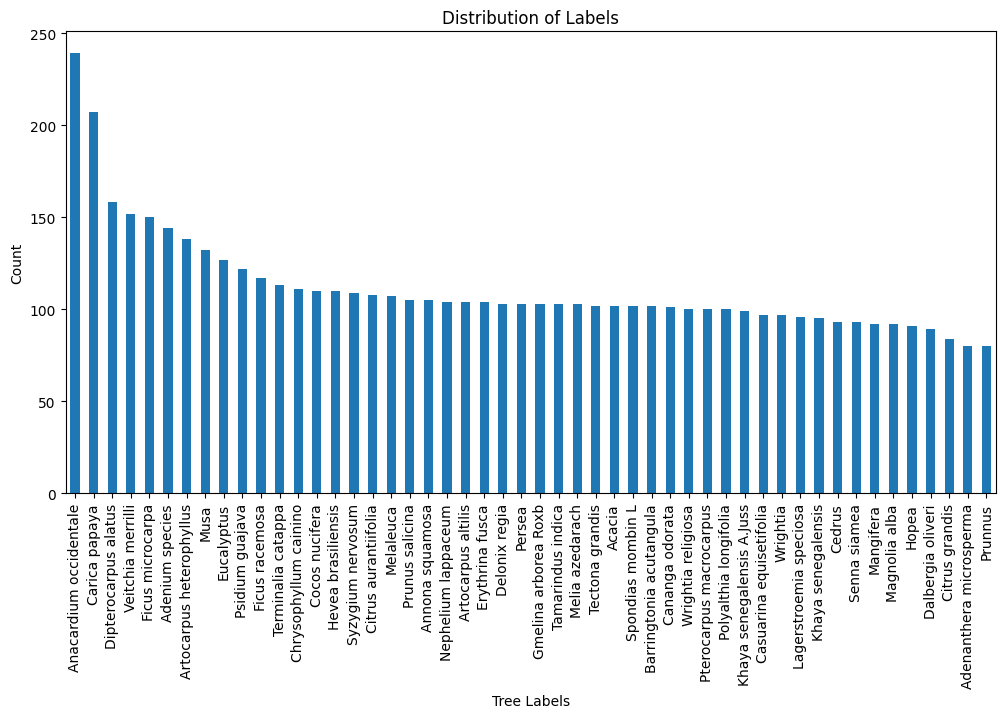

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Assuming your DataFrame is named df

# Count the occurrences of each label
label_counts = df['label'].value_counts()
# Plot the distribution
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [5]:
print(df['label'].unique())
print(len(df['label'].unique()))

['Wrightia' 'Wrightia religiosa' 'Tamarindus indica'
 'Lagerstroemia speciosa' 'Khaya senegalensis' 'Casuarina equisetifolia'
 'Erythrina fusca' 'Melaleuca' 'Dipterocarpus alatus' 'Artocarpus altilis'
 'Prunnus' 'Veitchia merrilli' 'Adenium species' 'Anacardium occidentale'
 'Polyalthia longifolia' 'Ficus microcarpa' 'Melia azedarach'
 'Spondias mombin L' 'Cananga odorata' 'Artocarpus heterophyllus'
 'Gmelina arborea Roxb' 'Hevea brasiliensis' 'Dalbergia oliveri'
 'Barringtonia acutangula' 'Syzygium nervosum' 'Persea' 'Carica papaya'
 'Chrysophyllum cainino' 'Musa' 'Magnolia alba' 'Eucalyptus' 'Mangifera'
 'Prunus salicina' 'Cedrus' 'Khaya senegalensis A.Juss' 'Ficus racemosa'
 'Psidium guajava' 'Nephelium lappaceum' 'Tectona grandis'
 'Pterocarpus macrocarpus' 'Delonix regia' 'Annona squamosa'
 'Terminalia catappa' 'Cocos nucifera' 'Citrus grandis'
 'Adenanthera microsperma' 'Acacia' 'Hopea' 'Senna siamea'
 'Citrus aurantiifolia']
50


In [6]:
# EXIF 데이터를 통해 이미지 방향을 수정하는 함수
def correct_image_orientation(img):
    try:
        exif = img._getexif()
        if exif is not None:
            for orientation_tag, orientation_value in ExifTags.TAGS.items():
                if orientation_value == 'Orientation':
                    orientation = exif.get(orientation_tag)
                    if orientation == 3:
                        img = img.rotate(180, expand=True)
                    elif orientation == 6:
                        img = img.rotate(270, expand=True)
                    elif orientation == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError, TypeError):
        # EXIF 데이터가 없거나, 태그를 찾을 수 없거나, 이미지 포맷이 EXIF를 지원하지 않는 경우
        pass
    return img

In [7]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [8]:
df

,label,path,label_encoded
0,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
1,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
2,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
3,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
4,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
...,...,...,...
5573,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5574,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5575,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5576,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13


In [9]:
train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

In [10]:
df

,label,path,label_encoded
0,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
1,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
2,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
3,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
4,Wrightia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
...,...,...,...
5573,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5574,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5575,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
5576,Citrus aurantiifolia,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13


In [11]:
train

,path,label_encoded
3173,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Car...,9
489,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Kha...,26
5286,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Hop...,25
2291,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Art...,6
4806,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Ter...,46
...,...,...
1688,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Pol...,36
4639,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Del...,17
585,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cas...,10
4618,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Del...,17


In [12]:
valid

,path,label_encoded
4458,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Tec...,45
4787,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Ann...,4
90,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
1367,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Ade...,2
5572,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Cit...,13
...,...,...
2451,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Gme...,23
109,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,49
454,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Kha...,26
3762,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Pru...,38


In [13]:
test

,path,label_encoded
4409,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Tec...,45
2826,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Syz...,43
1215,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Vei...,47
1872,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Fic...,21
1225,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Vei...,47
...,...,...
3874,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Ced...,11
2654,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Dal...,16
1304,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Ade...,2
1052,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Art...,5


In [14]:
BATCH_SIZE = 16

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)
        
        return image, label


transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=target_mean, std=target_std),
])

flip_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

bright_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=(0.5, 0.9),),
    transforms.ToTensor()
])

bright2_transform = transforms.Compose([
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=(1.1, 1.5),),
    transforms.ToTensor()
])

VerticalFlip_transform = transforms.Compose([ # 상하반전
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor()
])

rotate_transform = transforms.Compose([ 
    transforms.CenterCrop((180,180)),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

In [15]:
pyramid_folder = './gaussian_pyramid_level1'
os.makedirs(pyramid_folder, exist_ok=True)  # 폴더가 없으면 생성

In [16]:
def create_gaussian_pyramid(img_path, label_encoded, pyramid_folder, levels=2):
    img = cv2.imread(img_path)
    pyramid = [img_path]  # 원본 이미지 포함

    for level in range(1, levels):
        img = cv2.pyrDown(img)
        
        # 원본 파일명과 확장자 분리
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        
        # 새 파일명 생성
        resized_path = os.path.join(pyramid_folder, f"{name}_{label_encoded}_gaussian_pyramid_{level}{ext}")
        cv2.imwrite(resized_path, img)
        pyramid.append(resized_path)

    return pyramid

In [17]:
extended_data = []
for _, row in train.iterrows():
    pyramid_paths = create_gaussian_pyramid(row['path'], row['label_encoded'], pyramid_folder)
    for path in pyramid_paths:
        extended_data.append({'path': path, 'label_encoded': row['label_encoded']})

extended_df = pd.DataFrame(extended_data)


In [18]:
extended_df

,path,label_encoded
0,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Car...,9
1,./gaussian_pyramid_level1/IMG_5257_9_gaussian_...,9
2,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Kha...,26
3,./gaussian_pyramid_level1/IMG_4712_26_gaussian...,26
4,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Hop...,25
...,...,...
7803,./gaussian_pyramid_level1/IMG_5438_10_gaussian...,10
7804,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Del...,17
7805,./gaussian_pyramid_level1/IMG_4518_17_gaussian...,17
7806,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Pte...,40


In [19]:
extended_df.to_csv('g_pyramid_lv2_dataframe.csv', index=False)

In [20]:
# CSV 파일을 데이터 프레임으로 읽기
extended_df = pd.read_csv('g_pyramid_lv2_dataframe.csv')

In [21]:
train = extended_df
train

,path,label_encoded
0,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Car...,9
1,./gaussian_pyramid_level1/IMG_5257_9_gaussian_...,9
2,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Kha...,26
3,./gaussian_pyramid_level1/IMG_4712_26_gaussian...,26
4,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Hop...,25
...,...,...
7803,./gaussian_pyramid_level1/IMG_5438_10_gaussian...,10
7804,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Del...,17
7805,./gaussian_pyramid_level1/IMG_4518_17_gaussian...,17
7806,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Pte...,40


In [22]:
# 원하는 원본 이미지 파일명
original_image_name = 'IMG_3762'

# 해당 원본 이미지의 피라미드 이미지들을 필터링
pyramid_images = train[train['path'].str.contains(original_image_name)]

# 결과 출력
pyramid_images

,path,label_encoded
7446,/kaggle/input/BarkVN-50/BarkVN-50_mendeley/Wri...,48
7447,./gaussian_pyramid_level1/IMG_3762_48_gaussian...,48


In [23]:
train_dataset = TreeDataset(dataframe=train, transform=transform)
flip_dataset = TreeDataset(dataframe=train, transform=flip_transform)
verflip_dataset = TreeDataset(dataframe=train, transform=VerticalFlip_transform)
bright_dataset = TreeDataset(dataframe=train, transform=bright_transform)
bright2_dataset = TreeDataset(dataframe=train, transform=bright2_transform)
rotate_dataset = TreeDataset(dataframe=train, transform=rotate_transform)
train_dataset = train_dataset + flip_dataset + bright_dataset + verflip_dataset + bright2_dataset + rotate_dataset

test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

46848
837
837


In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2928
53
53


In [25]:
# pyraimd_dataset = TreeDataset(dataframe=pyramid_images, transform=transform)
# len(pyraimd_dataset)

# pyraimd_loader = DataLoader(pyraimd_dataset, batch_size=1, shuffle=False, num_workers=0)


# fig, axes = plt.subplots(nrows=1, ncols=4)  # 충분한 크기로 설정합니다.
# axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환합니다.

# for i, (image, label) in enumerate(pyraimd_loader):
#     image = image.squeeze(0)  # 배치 차원을 제거합니다
#     ax = axes[i]
#     ax.imshow(image.detach().cpu().permute(1, 2, 0).numpy())  # CHW -> HWC
#     ax.set_title(f'Class: {label}')
#     ax.axis('off')



In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
num_classes = len(df['label_encoded'].unique())
model = models.convnext_small(pretrained=True).to(device)

# 파라미터 고정
for param in model.parameters():
    param.requires_grad = False

# 마지막 분류기 레이어 교체
model.classifier[2] = nn.Linear(768, num_classes).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 260MB/s]


In [28]:
# model = models.resnet101(pretrained=True).to(device)
# num_classes = len(df['label_encoded'].unique())

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#     nn.Linear(2048, 128),
#     nn.ReLU(inplace = True),
#     nn.Linear(128, num_classes)).to(device)



In [29]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 40
best_val_accuracy = 0.0  # 최고의 검증 정확도를 저장하기 위한 변수

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(valid_loader)
        print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')

        # 최고의 검증 정확도일 때 모델 저장
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), '/kaggle/working/conv_py1.pth')
            print('Best model saved.')

# 전체 학습이 끝난 후 최고의 모델을 저장했습니다.

Epoch 1/40: 100%|██████████| 2928/2928 [13:25<00:00,  3.63it/s]


Training Loss: 0.8856430044524941
Validation Loss: 0.3330941586491634, Validation Accuracy: 91.40%
Best model saved.


Epoch 2/40: 100%|██████████| 2928/2928 [13:26<00:00,  3.63it/s]


Training Loss: 0.36056420009626494
Validation Loss: 0.25768521038885667, Validation Accuracy: 93.19%
Best model saved.


Epoch 3/40: 100%|██████████| 2928/2928 [13:27<00:00,  3.63it/s]


Training Loss: 0.2645198187884325
Validation Loss: 0.21143819187231855, Validation Accuracy: 93.79%
Best model saved.


Epoch 4/40: 100%|██████████| 2928/2928 [13:27<00:00,  3.62it/s]


Training Loss: 0.2160274216366418
Validation Loss: 0.18710755244916621, Validation Accuracy: 94.98%
Best model saved.


Epoch 5/40: 100%|██████████| 2928/2928 [13:27<00:00,  3.63it/s]


Training Loss: 0.18721343242548039
Validation Loss: 0.1622856483544346, Validation Accuracy: 95.10%
Best model saved.


Epoch 6/40: 100%|██████████| 2928/2928 [13:27<00:00,  3.63it/s]


Training Loss: 0.16987973089589764
Validation Loss: 0.1791665326608433, Validation Accuracy: 94.50%


Epoch 7/40: 100%|██████████| 2928/2928 [13:28<00:00,  3.62it/s]


Training Loss: 0.15276029131800997
Validation Loss: 0.15185443021770004, Validation Accuracy: 95.94%
Best model saved.


Epoch 8/40: 100%|██████████| 2928/2928 [13:29<00:00,  3.62it/s]


Training Loss: 0.1431088661161904
Validation Loss: 0.15381730803758573, Validation Accuracy: 96.06%
Best model saved.


Epoch 9/40: 100%|██████████| 2928/2928 [13:34<00:00,  3.60it/s]


Training Loss: 0.13610043508474445
Validation Loss: 0.15150936405703794, Validation Accuracy: 95.58%


Epoch 10/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.12966288055553168
Validation Loss: 0.1503799224155955, Validation Accuracy: 95.82%


Epoch 11/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.12206602183918808
Validation Loss: 0.15733322750706719, Validation Accuracy: 96.18%
Best model saved.


Epoch 12/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.11582666849779323
Validation Loss: 0.1440029551282213, Validation Accuracy: 96.77%
Best model saved.


Epoch 13/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.60it/s]


Training Loss: 0.11187557428340986
Validation Loss: 0.1556019764206178, Validation Accuracy: 95.94%


Epoch 14/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.10852109603001736
Validation Loss: 0.14474845218034527, Validation Accuracy: 96.18%


Epoch 15/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.10572290555272625
Validation Loss: 0.13744370577245169, Validation Accuracy: 96.54%


Epoch 16/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.60it/s]


Training Loss: 0.10321383771495009
Validation Loss: 0.14867761775537972, Validation Accuracy: 96.06%


Epoch 17/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.10134841442188608
Validation Loss: 0.1465595659132957, Validation Accuracy: 95.82%


Epoch 18/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.09626403666361064
Validation Loss: 0.1431970843919119, Validation Accuracy: 96.18%


Epoch 19/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.09301386001876043
Validation Loss: 0.14657929883208642, Validation Accuracy: 96.30%


Epoch 20/40: 100%|██████████| 2928/2928 [13:33<00:00,  3.60it/s]


Training Loss: 0.09277246808898006
Validation Loss: 0.13417216363339596, Validation Accuracy: 96.65%


Epoch 21/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.09052131881051417
Validation Loss: 0.1365777266035812, Validation Accuracy: 96.18%


Epoch 22/40: 100%|██████████| 2928/2928 [13:29<00:00,  3.62it/s]


Training Loss: 0.09121175130104979
Validation Loss: 0.14016552752980474, Validation Accuracy: 96.30%


Epoch 23/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.60it/s]


Training Loss: 0.09068494694095092
Validation Loss: 0.13252054850042597, Validation Accuracy: 96.30%


Epoch 24/40: 100%|██████████| 2928/2928 [13:39<00:00,  3.57it/s]


Training Loss: 0.08699239079439886
Validation Loss: 0.1284713610143712, Validation Accuracy: 96.77%


Epoch 25/40: 100%|██████████| 2928/2928 [13:37<00:00,  3.58it/s]


Training Loss: 0.08448723420394737
Validation Loss: 0.1349507342759198, Validation Accuracy: 96.42%


Epoch 26/40: 100%|██████████| 2928/2928 [13:35<00:00,  3.59it/s]


Training Loss: 0.08875960159696579
Validation Loss: 0.12998673932589502, Validation Accuracy: 96.65%


Epoch 27/40: 100%|██████████| 2928/2928 [13:34<00:00,  3.59it/s]


Training Loss: 0.08211544669662703
Validation Loss: 0.12400580311980278, Validation Accuracy: 96.77%


Epoch 28/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.07892208486623313
Validation Loss: 0.13295836229131827, Validation Accuracy: 96.30%


Epoch 29/40: 100%|██████████| 2928/2928 [13:33<00:00,  3.60it/s]


Training Loss: 0.08028860507895923
Validation Loss: 0.12266571480914827, Validation Accuracy: 96.65%


Epoch 30/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.07951002742688935
Validation Loss: 0.12941208574602034, Validation Accuracy: 96.54%


Epoch 31/40: 100%|██████████| 2928/2928 [13:29<00:00,  3.62it/s]


Training Loss: 0.0776544150855488
Validation Loss: 0.14466520961976576, Validation Accuracy: 96.18%


Epoch 32/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.61it/s]


Training Loss: 0.07931488579115069
Validation Loss: 0.13726142280381093, Validation Accuracy: 96.77%


Epoch 33/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.60it/s]


Training Loss: 0.07630212357849886
Validation Loss: 0.1311135405713119, Validation Accuracy: 96.77%


Epoch 34/40: 100%|██████████| 2928/2928 [13:28<00:00,  3.62it/s]


Training Loss: 0.07439254155890976
Validation Loss: 0.13745073509224587, Validation Accuracy: 96.77%


Epoch 35/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.07648180793199985
Validation Loss: 0.13159675820260985, Validation Accuracy: 96.77%


Epoch 36/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.0745010456366911
Validation Loss: 0.1401992130229203, Validation Accuracy: 96.77%


Epoch 37/40: 100%|██████████| 2928/2928 [13:30<00:00,  3.61it/s]


Training Loss: 0.07238086756072401
Validation Loss: 0.1528428355508033, Validation Accuracy: 96.30%


Epoch 38/40: 100%|██████████| 2928/2928 [13:29<00:00,  3.62it/s]


Training Loss: 0.0737236193122864
Validation Loss: 0.13967699356266475, Validation Accuracy: 95.82%


Epoch 39/40: 100%|██████████| 2928/2928 [13:32<00:00,  3.60it/s]


Training Loss: 0.07486947797238377
Validation Loss: 0.12648256678442882, Validation Accuracy: 97.25%
Best model saved.


Epoch 40/40: 100%|██████████| 2928/2928 [13:31<00:00,  3.61it/s]


Training Loss: 0.07174177498819775
Validation Loss: 0.14363303761141016, Validation Accuracy: 96.42%


## Test

In [30]:
model.load_state_dict(torch.load('/kaggle/working/conv_py1.pth'))
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [31]:
from sklearn.metrics import precision_score, recall_score

# 예측값과 실제 라벨을 저장할 리스트 초기화
all_predicted = []
all_labels = []

total_correct = 0
total_samples = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# precision과 recall 계산
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")


Test Accuracy: 96.30%
Precision: 96.14%
Recall: 95.77%


In [32]:
from sklearn.metrics import classification_report

# 예측값과 실제 라벨을 저장할 리스트 초기화
all_predicted = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# LabelEncoder를 사용하여 숫자로 인코딩한 클래스 이름을 가져옴
class_names = label_encoder.classes_

# 클래스별 성능 지표 출력
print(classification_report(all_labels, all_predicted, target_names=class_names))

                           precision    recall  f1-score   support

                   Acacia       1.00      1.00      1.00        16
  Adenanthera microsperma       0.91      0.83      0.87        12
          Adenium species       1.00      1.00      1.00        21
   Anacardium occidentale       1.00      1.00      1.00        36
          Annona squamosa       1.00      1.00      1.00        15
       Artocarpus altilis       1.00      1.00      1.00        15
 Artocarpus heterophyllus       1.00      1.00      1.00        21
  Barringtonia acutangula       1.00      1.00      1.00        16
          Cananga odorata       0.88      1.00      0.94        15
            Carica papaya       1.00      1.00      1.00        31
  Casuarina equisetifolia       0.72      0.93      0.81        14
                   Cedrus       1.00      1.00      1.00        14
    Chrysophyllum cainino       1.00      1.00      1.00        16
     Citrus aurantiifolia       0.94      1.00      0.97     

In [33]:
from torchsummary import summary

# 모델의 요약 확인
summary(model, input_size=(3, 224, 224)) 

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot

# 모델의 그래프 생성
x = torch.randn(1, 3, 224, 224).to(device)  # 모델의 입력 크기에 맞는 더미 입력 생성
dot = make_dot(model(x), params=dict(model.named_parameters()))

# 그래프 저장
dot.render("model_graph", format="png")

# 그래프 출력
dot
